# Random Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz
from dfwiz import dfwiz_compare

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates
from utils.pipelines import scale_impute_via_pipeline

In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        pipeline_final = copy.deepcopy(pipe)
        pipeline_final.set_params(**best_params)
        pipeline_final.fit(X_train, y_train.values.ravel())
    else:
        pipeline_final = None

    return score, best_params, pipeline_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [12]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [13]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [14]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])
query = "select * from all_scr_preadmission_75_JOIN_6hr_fix"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [15]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [16]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

# outcome_var.append('min_day_rrt_present')


# first_24h = 1
# data= data[data[outcome_var].min(axis=1)>first_24h]

In [17]:
data.shape

(46300, 111)

In [18]:
data[data['min_day_rrt_present']<=1].shape

(1376, 111)

In [19]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [20]:
data[data['ckd']==1].shape

(7354, 111)

In [21]:
data = data[data['ckd']==0]

In [22]:
data[data['kidney_transplant']==1].shape

(127, 111)

In [23]:
data = data[data['kidney_transplant']==0]

In [24]:
# data = data[data['egfr_mdrd_scr']>60]

In [25]:
# data[data.egfr_mdrd_scr<60].shape

In [26]:
data.head(5)

,,aki_kdigo_grade_1,aki_kdigo_grade_2,aki_kdigo_grade_3,day_detection_kdigo_grade_1,day_detection_kdigo_grade_2,day_detection_kdigo_grade_3,aki_mkdigo_grade_1,aki_mkdigo_grade_2,aki_mkdigo_grade_3,day_detection_mkdigo_grade_1,day_detection_mkdigo_grade_2,day_detection_mkdigo_grade_3,age,female,ethnicity,ckd,is_mdrd,egfr_epi_scr,egfr_mdrd_scr,kidney_transplant,congestive_heart_failure,diabetes_type2,chronic_kidney_disease,hypertension,obesity_icd,peripheral_vascular_disease,chronic_liver_disease,mild_liver_disease,severe_liver_disease,myocardial_infarct,chronic_pulmonary_disease,chronic_heart_failure,sepsis,hematocrit_min,hematocrit_max,hemoglobin_min,hemoglobin_max,platelets_min,platelets_max,wbc_min,wbc_max,wbc_bd_min,wbc_bd_max,albumin_min,albumin_max,globulin_min,globulin_max,total_protein_min,total_protein_max,aniongap_min,aniongap_max,bicarbonate_min,bicarbonate_max,bun_min,bun_max,calcium_min,calcium_max,chloride_min,chloride_max,creatinine_min,creatinine_max,glucose_min,glucose_max,sodium_min,sodium_max,potassium_min,potassium_max,pt_min,pt_max,thrombin_min,thrombin_max,ptt_min,ptt_max,inr_min,inr_max,bilirubin_total_min,bilirubin_total_max,egfr_epi_scr_max,egfr_mdrd_scr_max,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,dbp_min,dbp_max,dbp_mean,resp_rate_min,resp_rate_max,resp_rate_mean,temperature_min,temperature_max,temperature_mean,spo2_min,spo2_max,arbs_acei,cyclosporine,bmi,urineoutput_24hr,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,min_day_rrt_present,min_day_rrt_active,weight_admit,weight_min,weight_max,hospital_expire_flag
stay_id,subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30529524,19052676,1,1,0,1.0,2.0,9999999.0,1,1,0,1.0,2.0,9999999.0,44.0,0,NaN,0,0,30.0,28.0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,24.6,24.6,7.7,7.7,442.0,442.0,14.5,14.5,14.5,14.5,NaN,NaN,NaN,NaN,NaN,NaN,16.0,18.0,25.0,26.0,30.0,37.0,9.1,9.2,94.0,95.0,1.4,1.9,107.0,141.0,136.0,138.0,3.9,4.2,16.4,16.4,NaN,NaN,27.6,40.4,1.5,1.5,0.6,0.6,42.0,39.0,82.0,138.0,100.906250,82.0,152.0,109.636364,31.0,72.0,39.030303,11.0,40.0,22.078125,36.61,38.28,37.453333,80.0,100.0,0,0,42.78,220.0,0,1,0,0,0,99999999.0,99999999.0,77.0,77.0,77.0,0
35949655,10240707,1,0,0,1.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,73.0,0,NaN,0,1,39.0,40.0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,28.0,33.2,9.4,10.9,150.0,202.0,13.1,16.4,13.1,16.4,3.3,3.3,NaN,NaN,NaN,NaN,16.0,21.0,16.0,18.0,80.0,84.0,7.9,8.6,105.0,111.0,1.3,1.7,118.0,124.0,139.0,141.0,4.2,5.1,11.7,14.6,NaN,NaN,21.3,26.1,1.1,1.3,0.3,0.3,39.0,40.0,80.0,100.0,87.636364,87.0,108.0,98.000000,53.0,71.0,63.900000,15.0,26.0,19.181818,36.83,37.22,37.025000,96.0,100.0,0,0,NaN,100.0,0,0,0,0,0,99999999.0,99999999.0,125.3,125.3,125.3,0
33571346,13443421,1,0,0,1.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,33.0,1,NaN,0,1,59.0,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,44.0,11.1,13.6,164.0,284.0,14.6,24.0,14.6,24.0,3.6,4.4,NaN,NaN,NaN,NaN,14.0,14.0,17.0,19.0,11.0,14.0,8.0,22.5,106.0,106.0,0.9,1.2,107.0,110.0,133.0,135.0,3.7,3.9,11.1,11.7,NaN,NaN,25.5,31.6,1.0,1.1,0.4,0.4,59.0,52.0,75.0,131.0,90.280000,88.0,123.0,102.500000,55.0,81.0,68.083333,12.0,31.0,20.000000,36.61,37.39,37.111250,90.0,100.0,0,0,NaN,350.0,0,1,0,0,0,99999999.0,99999999.0,59.8,59.8,59.8,0
30283046,10777271,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,2.0,9999999.0,9999999.0,54.0,0,NaN,0,1,62.0,58.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,41.0,42.4,13.7,14.7,179.0,204.0,13.6,15.3,13.6,15.3,3.5,3.5,NaN,NaN,NaN,NaN,12.0,14.0,20.0,22.0,10.0,15.0,7.0,8.0,113.0,116.0,1.2,1.3,94.0,151.0,144.0,146.0,3.2,3.4,11.3,11.3,NaN,NaN,32.7,32.7,1.0,1.0,0.2,0.2,62.0,58.0,83.0,101.0,90.150000,111.0,143.0,118.550000,62.0,100.0,78.000000,13.0,23.0,16.904762,37.00,39.00,37.568750,95.0,100.0,0,0,NaN,1500.0,0,0,0,0,0,99999999.0,99999999.0,83.5,83.5,83.5,0
36223916,10135398,0,0,0,9999999.0,9999999.0,9999999.0,1,0,0,1.0,9999999.0,9999999.0,59.0,0,WHITE,0,1,75.0,71.0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
# data.dropna(axis=1, thresh = int(0.3*data.shape[0]), inplace=True)

In [28]:
# pd.set_option('display.max_rows', None)

In [29]:
# data.isna().sum()/len(data)*100

In [30]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [31]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
# 'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [32]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [33]:
perc = 20 # remove rows with NaN is 80 or more in each row
min_count =  int(((100-perc)/100)*data.shape[0])
data.dropna(axis=1, thresh = min_count, inplace=True)

In [34]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [35]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [36]:
# data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
#                                             .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
#                                             .fillna('other').pipe(onehot)
# data_cat = data_cat.fillna('other').pipe(onehot)
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [114]:
data_cat.value_counts()

BLACK/AFRICAN AMERICAN  HISPANIC/LATINO  WHITE
0                       0                1        25516
                                         0         7702
1                       0                0         2941
0                       1                0         1284
dtype: int64

In [37]:
# processed = pd.merge(data_num, data_cat, left_index=True, right_index=True)
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [38]:
processed['is_mdrd'].sum()

24174

In [39]:
tmp1 = processed[processed['is_mdrd']==0]
tmp1.aki_kdigo_grade_1.value_counts()

0    8280
1    4989
Name: aki_kdigo_grade_1, dtype: int64

In [40]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

64.56213444435542

In [41]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [42]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])/processed.shape[0]

0.36514168202334213

In [43]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [44]:
df_X.female.value_counts()

0    20682
1    16761
Name: female, dtype: int64

In [45]:
df_y.outcome.value_counts()

0.0    23771
1.0    13672
Name: outcome, dtype: int64

In [46]:
df_y.shape

(37443, 1)

In [47]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split


X_train_0, X_valid, y_train_0, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) # 

X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=42, shuffle=True, stratify=y_train_0) #0.25 *0.8 = 0.2 for test and 0.75*0.8 = 0.60 for train


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


In [110]:
print(processed.describe().loc[['mean','std']].transpose().to_string())

                                   mean         std
aki_kdigo_grade_1              0.365142    0.481476
is_mdrd                        0.645621    0.478331
chronic_liver_disease          0.003151    0.056050
ckd                            0.000000    0.000000
female                         0.447640    0.497258
age                           63.304303   16.998671
aki_mkdigo_grade_2             0.200545    0.400413
peripheral_vascular_disease    0.096066    0.294686
aki_mkdigo_grade_3             0.050316    0.218600
aki_kdigo_grade_2              0.105894    0.307706
kidney_transplant              0.000000    0.000000
congestive_heart_failure       0.193548    0.395084
diabetes_type2                 0.237428    0.425512
hypertension                   0.542024    0.498238
obesity_icd                    0.065914    0.248134
aki_mkdigo_grade_1             0.675186    0.468311
aki_kdigo_grade_3              0.038432    0.192239
outcome                        0.365142    0.481476
egfr_mdrd_sc

In [144]:
processed.peripheral_vascular_disease.value_counts()

0    33846
1     3597
Name: peripheral_vascular_disease, dtype: int64

In [145]:
33846/37443

0.9039339796490666

: 

In [99]:
processed.describe()

,aki_kdigo_grade_1,is_mdrd,chronic_liver_disease,ckd,female,age,aki_mkdigo_grade_2,peripheral_vascular_disease,aki_mkdigo_grade_3,aki_kdigo_grade_2,kidney_transplant,congestive_heart_failure,diabetes_type2,hypertension,obesity_icd,aki_mkdigo_grade_1,aki_kdigo_grade_3,outcome,egfr_mdrd_scr_max,myocardial_infarct,chronic_pulmonary_disease,chronic_heart_failure,sepsis,hospital_expire_flag,creatinine_min,mild_liver_disease,severe_liver_disease,creatinine_max,arbs_acei,cyclosporine,supplemental_oxygen,invasive_vent,hfnc,non_invasive_vent,tracheostomy,egfr_epi_scr_max,bun_max,bun_min,bicarbonate_max,chloride_min,chloride_max,bicarbonate_min,hematocrit_min,hematocrit_max,sodium_min,sodium_max,heart_rate_max,heart_rate_mean,heart_rate_min,hemoglobin_max,hemoglobin_min,spo2_max,spo2_min,potassium_min,potassium_max,resp_rate_mean,resp_rate_max,resp_rate_min,aniongap_max,aniongap_min,sbp_mean,sbp_min,sbp_max,dbp_max,dbp_min,dbp_mean,glucose_min,glucose_max,wbc_max,wbc_bd_max,wbc_bd_min,wbc_min,weight_max,weight_min,urineoutput_24hr,platelets_max,platelets_min,weight_admit,temperature_max,temperature_mean,temperature_min,inr_min,inr_max,pt_max,pt_min,ptt_max,ptt_min,calcium_min,calcium_max,BLACK/AFRICAN AMERICAN,HISPANIC/LATINO,WHITE
count,37443.000000,37443.000000,37443.000000,37443.0,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.0,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37443.000000,37413.000000,37413.000000,37393.000000,37393.000000,37393.000000,37393.000000,37391.000000,37391.000000,37389.000000,37389.000000,37382.000000,37382.000000,37382.000000,37376.000000,37376.000000,37373.000000,37373.000000,37361.000000,37361.000000,37349.000000,37349.000000,37349.000000,37344.000000,37344.000000,37282.000000,37282.000000,37282.000000,37281.000000,37281.000000,37281.000000,37235.000000,37235.000000,37226.000000,37226.000000,37226.000000,37226.000000,37080.000000,37080.000000,36939.000000,36703.000000,36703.000000,36683.000000,36211.000000,36211.000000,36211.000000,34109.000000,34109.000000,34108.000000,34108.000000,33913.000000,33913.000000,33854.000000,33854.000000,37443.000000,37443.000000,37443.000000
mean,0.365142,0.645621,0.003151,0.0,0.447640,63.304303,0.200545,0.096066,0.050316,0.105894,0.0,0.193548,0.237428,0.542024,0.065914,0.675186,0.038432,0.365142,77.641936,0.147932,0.228614,0.109046,0.126646,0.070908,0.890214,0.103063,0.043880,1.070379,0.115562,0.000588,0.547045,0.321956,0.008760,0.012713,0.002457,75.983815,21.259883,17.728891,24.641460,102.389297,106.111839,22.171826,31.410513,35.827073,136.934152,139.675359,103.322021,84.917787,70.539837,11.877582,10.508950,99.467289,92.237070,3.872755,4.450877,18.941429,27.608758,12.260355,15.530232,12.502437,118.675551,93.289417,147.527748,88.235080,47.952831,64.252046,118.899208,159.592104,13.759881,13.760015,10.193728,10.193760,82.952457,81.167379,257.074988,227.529957,191.900008,81.405196,37.393266,36.867209,36.328371,1.273897,1.475988,16.116967,14.017327,41.173650,30.494704,8.156306,8.582735,0.078546,0.034292,0.681462
std,0.481476,0.478331,0.056050,0.0,0.497258,16.998671,0.400413,0.294686,0.218600,0.307706,0.0,0.395084,0.425512,0.498238,0.248134,0.468311,0.192239,0.481476,34.195932,0.355037,0.419946,0.311701,0.332580,0.256674,0.514929,0.304046,0.204831,0.682041,0.319704,0.024233,0.497789,0.467232,0.093185,0.112033,0.049509,27.237050,14.820976,12.422964,3.821921,5.976831,5.851775,4.323600,6.596969,6.015614,4.943783,4.619963,20.100606,15.503821,14.850050,2.092646,2.245005,1.042592,5.190793,0.518219,0.737230,3.662516,6.344381,3.492511,4.439454,3.047095,15.352752,16.169514,21.818919,19.125646,11.192245,10.944309,37.428975,94.966133,6.750009,6.749953,5.035887,5.035868,25.698825,24.509971,254

In [48]:
X_train_orginal,  y_train_orginal = X_train.copy(),  y_train.copy()

X_train,  y_train = [
    df.reset_index(drop=True)
    for df in up_sample(X_train, y_train,'outcome')]

In [95]:
X_train.describe()

,pt_max,temperature_mean,kidney_transplant,heart_rate_max,bun_max,potassium_min,resp_rate_min,sepsis,chronic_liver_disease,calcium_max,glucose_min,aniongap_max,temperature_max,hospital_expire_flag,platelets_min,sodium_min,bun_min,weight_admit,hemoglobin_min,dbp_min,sbp_min,sbp_max,egfr_mdrd_scr_max,bicarbonate_min,spo2_max,chronic_heart_failure,ptt_max,diabetes_type2,arbs_acei,wbc_max,platelets_max,weight_max,mild_liver_disease,congestive_heart_failure,chloride_max,bicarbonate_max,supplemental_oxygen,hematocrit_max,ckd,wbc_bd_max,obesity_icd,chloride_min,dbp_max,inr_min,creatinine_min,chronic_pulmonary_disease,wbc_bd_min,glucose_max,potassium_max,severe_liver_disease,pt_min,hypertension,dbp_mean,ptt_min,calcium_min,temperature_min,heart_rate_min,creatinine_max,BLACK/AFRICAN AMERICAN,cyclosporine,hematocrit_min,sbp_mean,tracheostomy,sodium_max,resp_rate_mean,spo2_min,heart_rate_mean,myocardial_infarct,invasive_vent,non_invasive_vent,hemoglobin_max,hfnc,female,WHITE,egfr_epi_scr_max,HISPANIC/LATINO,weight_min,resp_rate_max,age,wbc_min,inr_max,aniongap_min,urineoutput_24hr,peripheral_vascular_disease
count,26075.000000,27476.000000,28524.0,28487.000000,28501.000000,28465.000000,28470.000000,28524.000000,28524.000000,25780.000000,28359.000000,28445.000000,27476.000000,28524.000000,27974.000000,28490.000000,28501.000000,27914.000000,28483.000000,28416.000000,28416.000000,28416.000000,28524.000000,28497.000000,28483.000000,28524.000000,25937.000000,28524.000000,28524.000000,28362.000000,27974.000000,28264.000000,28524.000000,28524.000000,28491.000000,28497.000000,28524.000000,28491.000000,28524.0,28362.000000,28524.000000,28491.000000,28416.000000,26075.000000,28524.000000,28524.000000,28362.000000,28359.000000,28465.000000,28524.000000,26075.000000,28524.000000,28416.000000,25937.000000,25780.000000,27476.000000,28487.000000,28524.000000,28524.000000,28524.000000,28491.000000,28416.000000,28524.000000,28490.000000,28470.000000,28483.000000,28487.000000,28524.000000,28524.000000,28524.000000,28483.000000,28524.000000,28524.000000,28524.000000,28524.000000,28524.000000,28264.000000,28470.000000,28524.000000,28362.000000,26075.000000,28445.000000,28159.000000,28524.000000
mean,16.607651,36.862186,0.0,103.759883,22.810428,3.877892,12.277731,0.140969,0.004312,8.578871,118.730879,15.887994,37.401439,0.081335,189.543719,136.796525,18.875232,81.750168,10.381501,47.456855,92.531733,147.528540,73.350161,21.848405,99.494470,0.116218,42.035725,0.253541,0.115447,14.065717,227.539894,83.424716,0.108751,0.208807,106.264540,24.511959,0.549748,35.738623,0.0,14.065738,0.070818,102.257625,88.253414,1.291724,0.943749,0.234855,10.260331,165.109524,4.497657,0.049257,14.212533,0.549081,63.855010,30.646632,8.111618,36.306669,70.991224,1.158235,0.081896,0.000561,31.055537,118.133247,0.002279,139.717550,19.072709,92.101815,85.411762,0.156219,0.344271,0.012376,11.836825,0.008800,0.440366,0.678026,71.830529,0.033060,81.534987,27.765982,63.758905,10.260458,1.519806,12.562384,250.436983,0.100933
std,10.271755,0.504012,0.0,20.083239,16.020584,0.536540,3.554254,0.347996,0.065526,0.797201,37.528434,4.790173,0.705606,0.273354,90.274951,5.089543,13.513518,24.201801,2.256400,11.289397,16.294340,21.894025,35.158969,4.450753,1.015605,0.320492,28.606159,0.435045,0.319566,6.947030,97.380120,25.009555,0.311331,0.406463,5.979118,3.836032,0.497528,6.083417,0.0,6.947013,0.256524,6.148470,19.379418,0.487278,0.588630,0.423916,5.150815,102.741343,0.762095,0.216407,4.950032,0.497594,11.001885,10.833476,0.842751,0.697711,14.972712,0.763917,0.274211,0.023678,6.634855,15.298518,0.047683,4.737973,3.747513,5.602116,15.555410,0.363070,0.475138,0.110557,2.105404,0.093394,0.496440,0.467241,28.402819,0.178796,23.783513,6.409227,16.991097,5.150762,0.990395,3.111850,255.546769,0.301245
min,8.600000,31.600000,0.0,36.000000,3.000000,1.500000,1.000000,0.000000,0.000000,5.400000,6.000000,5.000000,31.600000,0.000000,50.000000,74.000000,3.000000,1.000000,1.900000,3.000000,4.000000,78.000000,4.00

In [49]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42, sampling_strategy='auto')
# X_train, y_train = rus.fit_resample(X_train, y_train)

In [50]:
# dfwiz_compare(X_train,X_test, label=['df_train','df_test'])

In [51]:
df_y.value_counts()

outcome
0.0        23771
1.0        13672
dtype: int64

Index(['pt_max', 'temperature_mean', 'kidney_transplant', 'heart_rate_max',
       'bun_max', 'potassium_min', 'resp_rate_min', 'sepsis',
       'chronic_liver_disease', 'calcium_max', 'glucose_min', 'aniongap_max',
       'temperature_max', 'hospital_expire_flag', 'platelets_min',
       'sodium_min', 'bun_min', 'weight_admit', 'hemoglobin_min', 'dbp_min',
       'sbp_min', 'sbp_max', 'egfr_mdrd_scr_max', 'bicarbonate_min',
       'spo2_max', 'chronic_heart_failure', 'ptt_max', 'diabetes_type2',
       'arbs_acei', 'wbc_max', 'platelets_max', 'weight_max',
       'mild_liver_disease', 'congestive_heart_failure', 'chloride_max',
       'bicarbonate_max', 'supplemental_oxygen', 'hematocrit_max', 'ckd',
       'wbc_bd_max', 'obesity_icd', 'chloride_min', 'dbp_max', 'inr_min',
       'creatinine_min', 'chronic_pulmonary_disease', 'wbc_bd_min',
       'glucose_max', 'potassium_max', 'severe_liver_disease', 'pt_min',
       'hypertension', 'dbp_mean', 'ptt_min', 'calcium_min', 'temperature_

___________________
### Define pipeline

In [53]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

___________________
### Cross validation search

In [ ]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid ={'model__num_leaves': [6, 10, 20, 50], 
#              'model__min_child_samples': [100, 200, 300, 400, 500], 
#              'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
#              'model__subsample' : [0.2, 0.5, 0.8], 
#              'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
#              'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






# score, best_params, pipeline_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [ ]:
# import lightgbm as lgbm  # standard alias

# pipe = Pipeline(steps=[
# # ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan, sample_posterior=True)),
# ('model', lgbm.LGBMClassifier(n_jobs=-1))
# ])

In [ ]:
# from skopt import BayesSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score


# bayes_cv_tuner = BayesSearchCV(
#     estimator = pipe
#     ,search_spaces = {
#         'model__n_estimators': (100,200,300,400),
#         'model__num_leaves': (6, 10, 20, 50), 
#         'model__min_child_samples': (100, 200, 300, 400, 500), 
#         'model__min_child_weight': (1e-5,  1e-2,  1,  1e2,  1e4),
#         'model__subsample' : (0.2, 0.5, 0.8), 
#         'model__reg_alpha': (0, 1e-1, 1, 5,  10, 50, 100),
#         'model__reg_lambda': (0, 1e-1, 1,  10,  50, 100)

#     }, 
#     cv = StratifiedKFold(
#         n_splits=5,
#         shuffle=True,
#     ),
#     # cv=3,
#     n_jobs = 3,
#     n_iter = 10,   
#     verbose = 0,
#     scoring='f1'
# )

# sample_ratio = 0.1
# n_samples = int(len(X_train)*sample_ratio)
# X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
# result = bayes_cv_tuner.fit(X, y.ravel())
# # print(result.score(X_test, y_test))
# print(result.best_params_)
# print(result.best_score_)

__________
### Fitting Pipeline one time



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



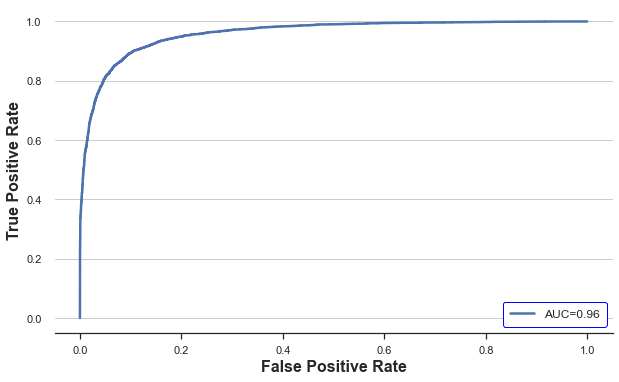

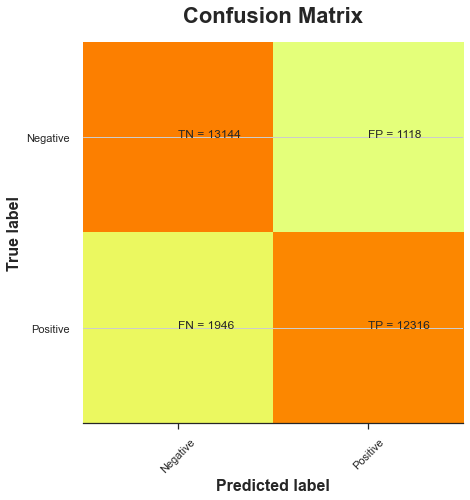


Classification report

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90     14262
         1.0       0.92      0.86      0.89     14262

    accuracy                           0.89     28524
   macro avg       0.89      0.89      0.89     28524
weighted avg       0.89      0.89      0.89     28524


_________________________________________

Specificity

0.92

_________________________________________


In [54]:
# manual params setting
# best_params = {'model__num_leaves': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 0.01, 'model__subsample': 0.8, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 20, 'model__min_child_samples': 300, 'model__min_child_weight': 0.01, 'model__subsample': 0.2, 'model__reg_alpha': 1, 'model__reg_lambda': 50}
# best_params = {'model__min_child_samples': 300, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__num_leaves': 20, 'model__reg_alpha': 1.0, 'model__reg_lambda': 50, 'model__subsample': 0.2}
best_params = {'model__n_estimators': 400,'model__num_leaves': 50, 'model__min_child_samples': 100, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}
# Or get parameters from search above
best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.outcome.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
## Validate on validation set

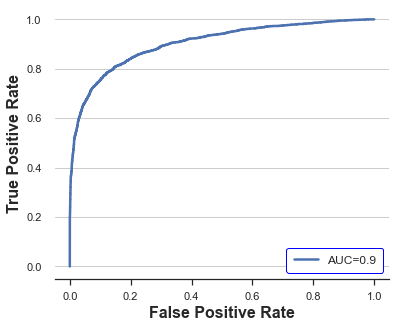

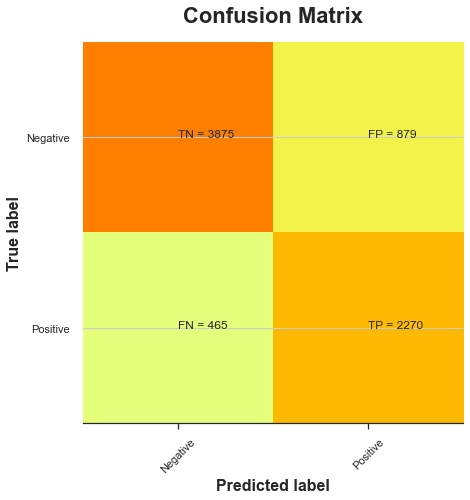


Classification report

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85      4754
         1.0       0.72      0.83      0.77      2735

    accuracy                           0.82      7489
   macro avg       0.81      0.82      0.81      7489
weighted avg       0.83      0.82      0.82      7489


_________________________________________

Specificity

0.82

_________________________________________


In [55]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.38

X,y = X_valid.values, y_valid.values

y_pred_valid = pipeline_final.predict(X)
y_pred_proba_valid = pipeline_final.predict_proba(X)
y_pred_valid  = (y_pred_proba_valid[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_valid, y_pred_proba_valid)


## Validate on hold-out test set

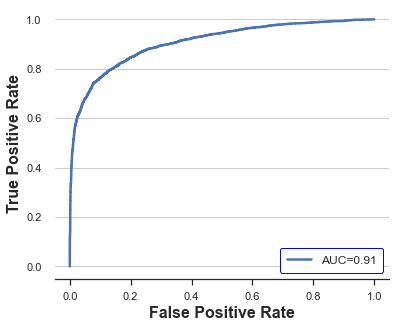

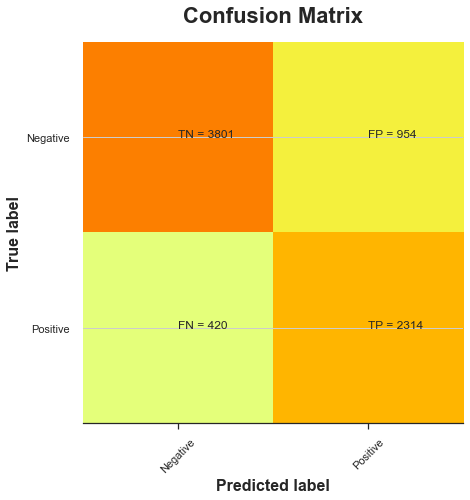


Classification report

              precision    recall  f1-score   support

         0.0       0.90      0.80      0.85      4755
         1.0       0.71      0.85      0.77      2734

    accuracy                           0.82      7489
   macro avg       0.80      0.82      0.81      7489
weighted avg       0.83      0.82      0.82      7489


_________________________________________

Specificity

0.8

_________________________________________


In [56]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.36

X,y = X_test.values, y_test.values

y_pred_test = pipeline_final.predict(X)
y_pred_proba_test = pipeline_final.predict_proba(X)
y_pred_test  = (y_pred_proba_test[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_test, y_pred_proba_test)


## Histograms

In [57]:
# combining X_test,y_test and y_pred in one dataset
# del(df_test_all)
df_test_all = X_valid.copy()
df_test_all['y_actual'] = y_valid
df_test_all['y_pred'] = y_pred_valid
# df_test_all

In [58]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [59]:
df_TN_valid = df_test_all[df_test_all.error_category==0]
df_FP_valid = df_test_all[df_test_all.error_category==1]

df_TP_valid = df_test_all[df_test_all.error_category==2]
df_FN_valid = df_test_all[df_test_all.error_category==3]

In [60]:
common_processed = processed2.copy()
common_FN = pd.merge(df_FN, common_processed, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
common_FN.drop([col for col in common_FN.columns if 'drop' in col], axis=1, inplace=True)

common_FN.aki_kdigo_grade_1.value_counts()

NameError: name 'df_FN' is not defined

In [ ]:
common_FN.aki_kdigo_grade_2.value_counts()

In [ ]:
common_FN.aki_kdigo_grade_3.value_counts()

## Dalex

In [61]:
import dalex as dx

exp = dx.Explainer(pipeline_final, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 28524 rows 84 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 28524 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7ff3efaee0d0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00841, mean = 0.499, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.988, mean = 0.000665, max = 0.975
  -> model_info        : package imblearn

A new explainer has been created!


In [62]:
exp.model_performance(model_type='classification').plot(geom='roc')

In [63]:
def scale_impute(df, pipe):
    data_scaled = pipe.named_steps['scaler'].transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    data_imputed = pipe.named_steps['imputer'].transform(df_scaled)
    df_result = pd.DataFrame(data_imputed, columns=df.columns)
    return df_result

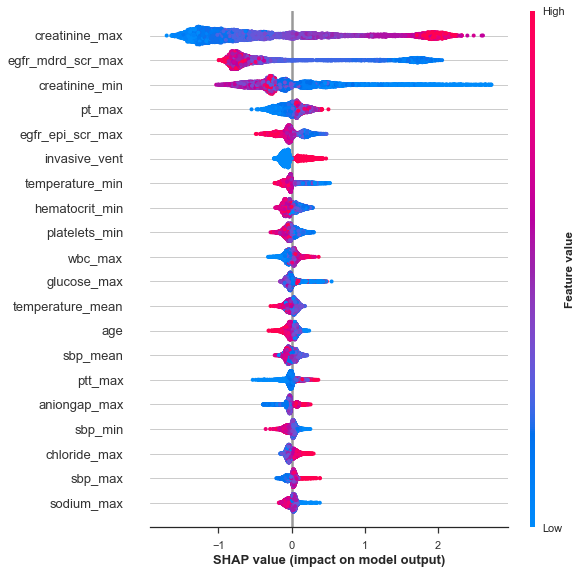

In [93]:
import shap
import matplotlib.pyplot as plt



X_valid_t = scale_impute(df=X_valid,pipe=pipeline_final)
shap.initjs()
explainer = shap.TreeExplainer(pipeline_final._final_estimator)
shap_values = explainer.shap_values(X_valid_t)
shap.summary_plot(shap_values[1], X_valid_t, max_display=20, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

In [65]:
exp.model_parts().plot(max_vars=30)

In [ ]:
y_test.iloc[[row_number]]

In [ ]:
y_pred[row_number]

In [ ]:
df_shap.iloc[[281]]

## Break-down plot using Dalex

In [ ]:
import random
random.seed(42)
rand_list = random.sample(range(0, df_FP_valid.shape[0]), 10)
# rand_list = [25, 142]

clf_threshold = 0.38
import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP_valid":df_FP_valid}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on false positive validation set with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100).plot(min_max=[0,1], max_vars=30, baseline=clf_threshold)

In [ ]:
import random
random.seed(42)
# rand_list = random.sample(range(0, df_FP.shape[0]), 10)

clf_threshold = 0.38
import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP_valid}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX SHAP on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100, type='shap').plot(min_max=[0,1], max_vars=30, baseline=clf_threshold)

In [ ]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

query = "select * from creatinine_baseline_preadmission_75_6hr_fix"
scr_baseline = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])


In [ ]:

scr_baseline_FP = pd.merge(df_FP_valid, scr_baseline, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
scr_baseline_FP.drop([col for col in scr_baseline_FP.columns if 'drop' in col], axis=1, inplace=True)

scr_baseline_TN = pd.merge(df_TN_valid, scr_baseline, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
scr_baseline_TN.drop([col for col in scr_baseline_TN.columns if 'drop' in col], axis=1, inplace=True)

scr_baseline_FN = pd.merge(df_FN_valid, scr_baseline, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
scr_baseline_FN.drop([col for col in scr_baseline_FN.columns if 'drop' in col], axis=1, inplace=True)

scr_baseline_TP = pd.merge(df_TP_valid, scr_baseline, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
scr_baseline_TP.drop([col for col in scr_baseline_TP.columns if 'drop' in col], axis=1, inplace=True)

In [ ]:
scr_baseline_FP.head(10)

In [ ]:
df_FP_valid.iloc[[142]]

In [ ]:
import seaborn as sns
# Sort the dataframe by target
target_0 = scr_baseline_FP
target_1 = scr_baseline_TN


sns.distplot(target_0[['scr_baseline']], hist=False, rug=False,color = 'red', label="FP")
sns.distplot(target_1[['scr_baseline']], hist=False, rug=False)

# sns.displot(data=target_0, x='scr_baseline', kind='kde', fill=True, palette=sns.color_palette('bright')[:3], height=5, aspect=1.5)



plt.show()


In [ ]:
scr_baseline_FP.loc[38320865,11760589]

In [ ]:
error_FP = scr_baseline_FP[((scr_baseline_FP.creatinine_max - scr_bscr_baseline_FPaseline_FN.scr_baseline)*88.4)>=26.5]

In [ ]:
error_FP.is_mdrd.value_counts()

In [ ]:
error_FP.shape

In [ ]:
scr_baseline_FN.scr_baseline.describe()

In [ ]:
scr_baseline_TP.scr_baseline.describe()

In [ ]:
scr_baseline_FP.scr_baseline.median()

In [ ]:
scr_baseline_TN.scr_baseline.median()

In [ ]:
scr_baseline_FN.scr_baseline.median()

In [ ]:
scr_baseline_TP.scr_baseline.median()

In [ ]:
error_FP = scr_baseline_FN[((scr_baseline_FP.egfr_epi_scr_max))>=1.093]
error_FP.is_mdrd.value_counts()

In [ ]:
scr_baseline_FP['creatinine_max_mmol'] = scr_baseline_FP['creatinine_max']*88.4
scr_baseline_FP['scr_baseline_mmol'] = scr_baseline_FP['scr_baseline']*88.4

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="scr_baseline", data=scr_baseline_FP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
egfr_60_FP = scr_baseline_FP[scr_baseline_FP.egfr_epi_scr_max<60]
(egfr_60_FP[(egfr_60_FP.scr_baseline>1.1)].shape[0])/(egfr_60_FP.shape[0])

In [ ]:
egfr_60_FP.scr_baseline.describe()

In [ ]:
egfr_60_FP_high_bl = egfr_60_FP[egfr_60_FP.scr_baseline>1.1]
egfr_60_FP_high_bl.is_mdrd.value_counts()

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="scr_baseline", data=scr_baseline_TP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
egfr_60_TN = scr_baseline_TN[scr_baseline_TN.egfr_epi_scr_max<60]
egfr_60_TN.scr_baseline.describe()

## egfr vs age

## FP

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="age", data=scr_baseline_FP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
(scr_baseline_FP[scr_baseline_FP.egfr_epi_scr_max<60].shape[0])/(scr_baseline_FP.shape[0])

## TN

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="age", data=scr_baseline_TN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)
# plt.text(x=60 , y=50 , s="hello", alpha=1, rotation='vertical')

In [ ]:
(scr_baseline_TN[scr_baseline_TN.egfr_epi_scr_max<60].shape[0])/(scr_baseline_TN.shape[0])

## FN

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="age", data=scr_baseline_FN, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
(scr_baseline_FN[scr_baseline_FN.egfr_epi_scr_max<60].shape[0])/(scr_baseline_FN.shape[0])

## TP

In [ ]:
import seaborn as sns
sns.jointplot(x="egfr_epi_scr_max", y="age", data=scr_baseline_TP, kind="hex", joint_kws={'color':"#66ffcc"})
plt.axvline(60, 0,10, linestyle='--', color = 'red', linewidth=1.5)
plt.axvline(90, 0,10, linestyle='--', color = 'red', linewidth=1.5)

In [ ]:
(scr_baseline_TP[scr_baseline_TP.egfr_epi_scr_max<60].shape[0])/(scr_baseline_TP.shape[0])

## 1- Retrain with new SCr baseline: minimum (MDRD, SCr pre-ICU)180-1 days before ICU admmission

In [ ]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [ ]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,ind1ex_col=['stay_id','subject_id','hadm_id'])
# query = "select * from all_scr_preadmission_75_join_180_0days"
# query = "select * from all_scr_preadmission_75_min_mdrd_7_180days_JOIN"
query = "select * from all_scr_preadmission_75_min_mdrd_1_180days_JOIN"


data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [ ]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [ ]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [ ]:
data = data[data['ckd']==0]

In [ ]:
data = data[data['kidney_transplant']==0]

In [ ]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [ ]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
# 'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [ ]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [ ]:
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [ ]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [ ]:
processed['is_mdrd'].sum()

In [ ]:
tmp1 = processed[processed['is_mdrd']==0]
tmp1.aki_kdigo_grade_1.value_counts()

In [ ]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

In [ ]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [ ]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])/processed.shape[0]

In [ ]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [ ]:
X, y = df_X, df_y

X_train2 = X_train_orginal.copy()
y_train2 = y_train_orginal.copy()

X_train_180_0days = X[X.index.isin(X_train2.index)]
y_train_180_0days = y[y.index.isin(y_train2.index)]


X_valid_180_0days = X[X.index.isin(X_valid.index)]
y_valid_180_0days = y[y.index.isin(y_valid.index)]

X_test_180_0days = X[X.index.isin(X_test.index)]
y_test_180_0days = y[y.index.isin(y_test.index)]



In [ ]:
X_train_180_0days,  y_train_180_0days = [
    df.reset_index(drop=True)
    for df in up_sample(X_train_180_0days, y_train_180_0days,'outcome')]

In [ ]:
X_test_180_0days.shape

___________________
### Define pipeline

In [ ]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

__________
### Fitting Pipeline one time

In [ ]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


param_grid ={'model__num_leaves': [6, 10, 20, 50], 
             'model__min_child_samples': [100, 200, 300, 400, 500], 
             'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
             'model__subsample' : [0.2, 0.5, 0.8], 
             'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
             'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






score, best_params, pipeline_final = param_graph(X_train_180_0days, y_train_180_0days, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [ ]:
# manual params setting
# best_params = {'model__num_leaves': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 0.01, 'model__subsample': 0.8, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 20, 'model__min_child_samples': 300, 'model__min_child_weight': 0.01, 'model__subsample': 0.2, 'model__reg_alpha': 1, 'model__reg_lambda': 50}
# best_params = {'model__min_child_samples': 300, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__num_leaves': 20, 'model__reg_alpha': 1.0, 'model__reg_lambda': 50, 'model__subsample': 0.2}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 50, 'model__min_child_samples': 80, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 10, 'model__min_child_samples': 100, 'model__min_child_weight': 1e-05, 'model__subsample': 0.8, 'model__reg_alpha': 1, 'model__reg_lambda': 0.1}
best_params = {'model__n_estimators': 400,'model__num_leaves': 10, 'model__min_child_samples': 100, 'model__min_child_weight': 0.001, 'model__subsample': 0.5, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# Or get parameters from search above
best_params2 = best_params

sample_ratio = 1


df_merged_X_train = X_train_180_0days.append(X_valid_180_0days, ignore_index=True)
df_merged_y_train = y_train_180_0days.append(y_valid_180_0days, ignore_index=True)

n_samples = int(len(df_merged_X_train)*sample_ratio)
X, y = resample(df_merged_X_train.values, df_merged_y_train.outcome.values, n_samples=n_samples, stratify=df_merged_y_train.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
## Validate on validation set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.38

X,y = X_valid_180_0days.values, y_valid_180_0days.values


y_pred_valid = pipeline_final.predict(X)
y_pred_proba_valid = pipeline_final.predict_proba(X)
y_pred_valid  = (y_pred_proba_valid[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_valid, y_pred_proba_valid)


## Validate on hold-out test set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.34

X,y = X_test_180_0days.values, y_test_180_0days.values


y_pred_test = pipeline_final.predict(X)
y_pred_proba_test = pipeline_final.predict_proba(X)
y_pred_test  = (y_pred_proba_test[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_test, y_pred_proba_test)


## 2- Retrain with new SCr baseline: minimum (MDRD, SCr pre-ICU) 180-7 days before ICU admmission

In [ ]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [ ]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,ind1ex_col=['stay_id','subject_id','hadm_id'])
query = "select * from all_scr_preadmission_75_min_mdrd_7_180days_JOIN"

data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [ ]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [ ]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [ ]:
data = data[data['ckd']==0]

In [ ]:
data = data[data['kidney_transplant']==0]

In [ ]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [ ]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
# 'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [ ]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [ ]:
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [ ]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [ ]:
processed['is_mdrd'].sum()

In [ ]:
tmp1 = processed[processed['is_mdrd']==0]
tmp1.aki_kdigo_grade_1.value_counts()

In [ ]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

In [ ]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [ ]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])/processed.shape[0]

In [ ]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [ ]:
X, y = df_X, df_y

X_train2 = X_train_orginal.copy()
y_train2 = y_train_orginal.copy()

X_train_180_7days = X[X.index.isin(X_train2.index)]
y_train_180_7days = y[y.index.isin(y_train2.index)]


X_valid_180_7days = X[X.index.isin(X_valid.index)]
y_valid_180_7days = y[y.index.isin(y_valid.index)]

X_test_180_7days = X[X.index.isin(X_test.index)]
y_test_180_7days = y[y.index.isin(y_test.index)]



In [ ]:
X_train_180_7days,  y_train_180_7days = [
    df.reset_index(drop=True)
    for df in up_sample(X_train_180_7days, y_train_180_7days,'outcome')]

In [ ]:
X_valid_180_0days.shape

___________________
### Define pipeline

In [ ]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

__________
### Fitting Pipeline one time

In [ ]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


param_grid ={'model__num_leaves': [6, 10, 20, 50], 
             'model__min_child_samples': [100, 200, 300, 400, 500], 
             'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
             'model__subsample' : [0.2, 0.5, 0.8], 
             'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
             'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






score, best_params, pipeline_final = param_graph(X_train_180_0days, y_train_180_0days, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [ ]:
# manual params setting
# best_params = {'model__num_leaves': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 0.01, 'model__subsample': 0.8, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 20, 'model__min_child_samples': 300, 'model__min_child_weight': 0.01, 'model__subsample': 0.2, 'model__reg_alpha': 1, 'model__reg_lambda': 50}
# best_params = {'model__min_child_samples': 300, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__num_leaves': 20, 'model__reg_alpha': 1.0, 'model__reg_lambda': 50, 'model__subsample': 0.2}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 50, 'model__min_child_samples': 80, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 10, 'model__min_child_samples': 100, 'model__min_child_weight': 1e-05, 'model__subsample': 0.8, 'model__reg_alpha': 1, 'model__reg_lambda': 0.1}
best_params = {'model__n_estimators': 400,'model__num_leaves': 6, 'model__min_child_samples': 100, 'model__min_child_weight': 1e-05, 'model__subsample': 0.2, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1}
# Or get parameters from search above
best_params2 = best_params


df_merged_X_train = X_train_180_0days.append(X_valid_180_7days, ignore_index=True)
df_merged_y_train = y_train_180_0days.append(y_valid_180_7days, ignore_index=True)

sample_ratio = 1
n_samples = int(len(df_merged_X_train)*sample_ratio)
X, y = resample(df_merged_X_train.values, df_merged_y_train.outcome.values, n_samples=n_samples, stratify=df_merged_y_train.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
## Validate on validation set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.38

X,y = X_valid_180_7days.values, y_valid_180_7days.values


y_pred_valid = pipeline_final.predict(X)
y_pred_proba_valid = pipeline_final.predict_proba(X)
y_pred_valid  = (y_pred_proba_valid[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_valid, y_pred_proba_valid)


## Validate on hold-out test set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.30

X,y = X_test_180_7days.values, y_test_180_7days.values


y_pred_test = pipeline_final.predict(X)
y_pred_proba_test = pipeline_final.predict_proba(X)
y_pred_test  = (y_pred_proba_test[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_test, y_pred_proba_test)


## 3- Retrain with new SCr baseline: pre-ICU admission 180 days to 1 days before ICU admmission

In [ ]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [ ]:

# query = "select * from all_scr_preadmission_75_join_180_0days"
query = "select * from all_scr_preadmission_75_join_180_0days"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

In [ ]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [ ]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [ ]:
data = data[data['ckd']==0]

In [ ]:
data = data[data['kidney_transplant']==0]

In [ ]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [ ]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
# 'ckd',
'chronic_kidney_disease'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

## Missingness percentage

In [ ]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [ ]:
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [ ]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [ ]:
processed['is_mdrd'].sum()

In [ ]:
tmp1 = processed[processed['is_mdrd']==0]
tmp1.aki_kdigo_grade_1.value_counts()

In [ ]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

In [ ]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [ ]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])/processed.shape[0]

In [ ]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [ ]:
X, y = df_X, df_y


X_train2 = X_train_orginal.copy()
y_train2 = y_train_orginal.copy()

X_train_min_mdrd_bl_180_0days = X[X.index.isin(X_train2.index)]
y_train_min_mdrd_bl_180_0days = y[y.index.isin(y_train2.index)]


X_valid_min_mdrd_bl_180_0days = X[X.index.isin(X_valid.index)]
y_valid_min_mdrd_bl_180_0days = y[y.index.isin(y_valid.index)]

X_test_min_mdrd_bl_180_0days = X[X.index.isin(X_test.index)]
y_test_min_mdrd_bl_180_0days = y[y.index.isin(y_test.index)]

X_train_180_0days,  y_train_180_0days = [
    df.reset_index(drop=True)
    for df in up_sample(X_train_min_mdrd_bl_180_0days, y_train_min_mdrd_bl_180_0days,'outcome')]

___________________
### Define pipeline

In [ ]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

___________________
### Cross validation search

In [ ]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid ={'model__num_leaves': [6, 10, 20, 50], 
#              'model__min_child_samples': [100, 200, 300, 400, 500], 
#              'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
#              'model__subsample' : [0.2, 0.5, 0.8], 
#              'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
#              'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






# score, best_params, pipeline_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [ ]:
# import lightgbm as lgbm  # standard alias

# pipe = Pipeline(steps=[
# # ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan, sample_posterior=True)),
# ('model', lgbm.LGBMClassifier(n_jobs=-1))
# ])

In [ ]:
# from skopt import BayesSearchCV
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score


# bayes_cv_tuner = BayesSearchCV(
#     estimator = pipe
#     ,search_spaces = {
#         'model__n_estimators': (100,200,300,400),
#         'model__num_leaves': (6, 10, 20, 50), 
#         'model__min_child_samples': (100, 200, 300, 400, 500), 
#         'model__min_child_weight': (1e-5,  1e-2,  1,  1e2,  1e4),
#         'model__subsample' : (0.2, 0.5, 0.8), 
#         'model__reg_alpha': (0, 1e-1, 1, 5,  10, 50, 100),
#         'model__reg_lambda': (0, 1e-1, 1,  10,  50, 100)

#     }, 
#     cv = StratifiedKFold(
#         n_splits=5,
#         shuffle=True,
#     ),
#     # cv=3,
#     n_jobs = 3,
#     n_iter = 10,   
#     verbose = 0,
#     scoring='f1'
# )

# sample_ratio = 0.1
# n_samples = int(len(X_train)*sample_ratio)
# X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
# result = bayes_cv_tuner.fit(X, y.ravel())
# # print(result.score(X_test, y_test))
# print(result.best_params_)
# print(result.best_score_)

__________
### Fitting Pipeline one time

In [ ]:
# manual params setting
# best_params = {'model__num_leaves': 20, 'model__min_child_samples': 100, 'model__min_child_weight': 0.01, 'model__subsample': 0.8, 'model__reg_alpha': 0, 'model__reg_lambda': 0.1}
# best_params = {'model__n_estimators': 400,'model__num_leaves': 20, 'model__min_child_samples': 300, 'model__min_child_weight': 0.01, 'model__subsample': 0.2, 'model__reg_alpha': 1, 'model__reg_lambda': 50}
# best_params = {'model__min_child_samples': 300, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__num_leaves': 20, 'model__reg_alpha': 1.0, 'model__reg_lambda': 50, 'model__subsample': 0.2}
best_params = {'model__n_estimators': 400,'model__num_leaves': 50, 'model__min_child_samples': 100, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}
# Or get parameters from search above
best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train_min_mdrd_bl_180_0days)*sample_ratio)
X, y = resample(X_train_min_mdrd_bl_180_0days.values, y_train_min_mdrd_bl_180_0days.outcome.values, n_samples=n_samples, stratify=y_train_min_mdrd_bl_180_0days.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
## Validate on validation set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.38

X,y = X_valid_min_mdrd_bl_180_0days.values, y_valid_min_mdrd_bl_180_0days.values

y_pred_valid = pipeline_final.predict(X)
y_pred_proba_valid = pipeline_final.predict_proba(X)
y_pred_valid  = (y_pred_proba_valid[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_valid, y_pred_proba_valid)


## Validate on hold-out test set

In [ ]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.30

X,y = X_test_min_mdrd_bl_180_0days.values, y_test_min_mdrd_bl_180_0days.values

y_pred_test = pipeline_final.predict(X)
y_pred_proba_test = pipeline_final.predict_proba(X)
y_pred_test  = (y_pred_proba_test[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred_test, y_pred_proba_test)
